In [135]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
import lifelines

# from lifelines import KaplanMeierFitter
# from lifelines.statistics import logrank_test
from scipy.stats import pearsonr, spearmanr, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
from matplotlib.pyplot import cm

In [136]:
import statsmodels.stats.multitest as multi

In [137]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [138]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get survival information

In [139]:
surv=pd.read_csv("/cellar/users/mpagadal/Data/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv",index_col=0)
surv=surv.rename(columns={"bcr_patient_barcode":"FID"})

## Get PCA information

In [140]:
surv_type="OS"

In [142]:
pheno=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/pca/phenotypes/pca.pheno.tsv",delimiter="\t",index_col=0)
print(pheno.shape)
pheno=pheno.replace(-9,np.nan)
del pheno["IID"]
pheno=pheno.reset_index()
pheno=pheno.rename(columns={"index":"FID"})

(7342, 11)


In [143]:
#filter out redacted samples
surv=surv[surv["Redaction"].isnull()]

In [144]:
comb_surv_pheno=pd.merge(surv[["FID","type",surv_type,surv_type+".time","age_at_initial_pathologic_diagnosis","race","gender","ajcc_pathologic_tumor_stage"]],pheno,on="FID",how="left")

In [145]:
#censor at 5 years
comb_surv_pheno=comb_surv_pheno[comb_surv_pheno[surv_type+".time"]<1825]

In [146]:
#get patients with Stage designations
comb_surv_pheno=comb_surv_pheno[comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.contains("Stage")]
comb_surv_pheno=comb_surv_pheno[~(comb_surv_pheno["ajcc_pathologic_tumor_stage"].isin(["Stage X"]))]

In [147]:
#split A,B,C from stage designations
comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("A").str[0]
comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("B").str[0]
comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("C").str[0]

In [148]:
comb_surv_pheno=comb_surv_pheno.join(pd.get_dummies(comb_surv_pheno["ajcc_pathologic_tumor_stage"]))

In [149]:
#get msi status and map
msi=pd.read_csv("/cellar/users/mpagadal/Data/resources/from-labmembers/andrea/MSI_MANTIS.txt",delimiter="\t")
mp_msi=dict(zip(msi["Case ID"],msi["msi"]))
comb_surv_pheno["MSI"]=comb_surv_pheno["FID"].map(mp_msi)

In [150]:
genes=pheno.columns[1:].tolist()

In [151]:
#combine all columns
cols=surv.columns[0:5].tolist()+["MSI"]+[surv_type,surv_type+".time"]+pd.get_dummies(comb_surv_pheno["ajcc_pathologic_tumor_stage"]).columns.tolist()+genes

In [152]:
comb_surv_pheno_clean=comb_surv_pheno[cols]

In [153]:
#remap gender
comb_surv_pheno_clean["gender"]=comb_surv_pheno_clean["gender"].map({"MALE":0,"FEMALE":1})

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [154]:
#remap msi status
comb_surv_pheno_clean["MSI"]=comb_surv_pheno_clean["MSI"].map({"MSS":0,"MSI-H":1})

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
#filter for only non-MSI-H patients
comb_surv_pheno_clean=comb_surv_pheno_clean[comb_surv_pheno_clean["MSI"]==0]

### Export data

In [156]:
for y in comb_surv_pheno_clean["type"].unique():
    df=comb_surv_pheno_clean[comb_surv_pheno_clean["type"]==y]
    df.to_csv("./"+surv_type+"-data/"+y+"."+surv_type+".pca.df",index=None)

## Run coxph.ipynb

In [157]:
cancers=comb_surv_pheno_clean["type"].unique().tolist()

In [158]:
cancer_counts=comb_surv_pheno_clean["type"].value_counts().reset_index()
cancers=cancer_counts[cancer_counts["type"]>100]["index"].tolist()

In [159]:
def ppoints(n, a):
    """ numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number"""
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

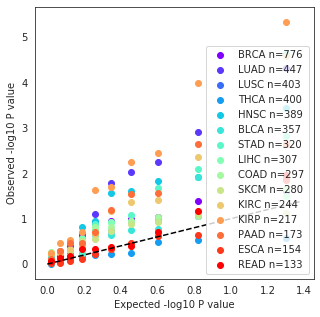

In [163]:
color=iter(cm.rainbow(np.linspace(0,1,len(cancers))))

df_coxph=pd.DataFrame()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for x in cancers:
    df=pd.read_csv("./"+surv_type+"-data/"+x+"."+surv_type+".pca.coxph.df")
    df=df[~df["Unnamed: 0"].isin(["Stage.I","age_at_initial_pathologic_diagnosis","Stage.IV","Stage.III","gender","Stage.II"])]
    #df=df[df["Unnamed: 0"].isin(genes)]
    df["cancer"]=x
    df_coxph=df_coxph.append(df)
    p_values=df.sort_values(by="p.value")["p.value"].tolist()
    c=next(color)
    plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values),label=x+" n="+str(cancer_counts[cancer_counts["index"]==x]["type"].tolist()[0]),color=c)
ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel('Observed -log10 P value')
plt.legend()
fig.savefig("immune."+surv_type+".coxph.qq.pdf")

## Compare Hazards Ratios

In [164]:
def fdr(df):
    #calculate benjamin-hochberg fdr
    probabilities = df["p.value"].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    return(df)

In [165]:
df_coxph_fdr=pd.DataFrame()

for i in cancers:
    df_canc=df_coxph[df_coxph["cancer"]==i]
    df_canc=fdr(df_canc)
    df_coxph_fdr=df_coxph_fdr.append(df_canc)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [166]:
df_coxph_fdr["hazards"]=df_coxph_fdr["HR (95% CI for HR)"].str.split(" ").str[0]
df_coxph_fdr["hazards"]=df_coxph_fdr["hazards"].astype(float)

4


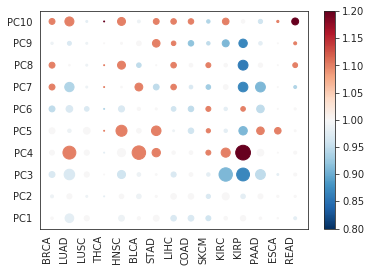

In [167]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=0.8, vmax=1.2# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    print(len(c))
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=df_coxph_fdr['cancer'],
    y=df_coxph_fdr['Unnamed: 0'],
    size=df_coxph_fdr['-log10(fdr)'],
    color=df_coxph_fdr['hazards'],
)


plt.savefig(surv_type+".hazards.pdf")

In [132]:
df_size=df_coxph_fdr.copy()

In [133]:
df_size["-log10(fdr)"]=np.where(df_size["cancer"]=="BRCA",2,df_size["-log10(fdr)"])
df_size["-log10(fdr)"]=np.where(df_size["cancer"]=="LUAD",1.3,df_size["-log10(fdr)"])
df_size["-log10(fdr)"]=np.where(df_size["cancer"]=="LUSC",1,df_size["-log10(fdr)"])
df_size["-log10(fdr)"]=np.where(df_size["cancer"]=="THCA",0.698,df_size["-log10(fdr)"])

4


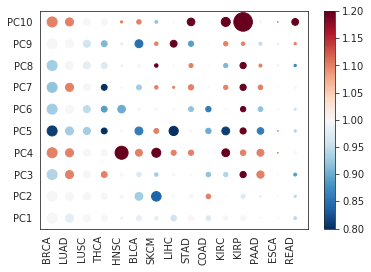

In [134]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r",vmin=0.8, vmax=1.2# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    print(len(c))
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=df_size['cancer'],
    y=df_size['Unnamed: 0'],
    size=df_size['-log10(fdr)'],
    color=df_size['hazards']
)


plt.savefig(surv_type+".size.pdf")